In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pandas import read_pickle
from meteostat import Point, Hourly
from tqdm import tqdm
from datetime import datetime, timedelta

# plt.rcParams['font.family']='Times New Roman,Microsoft YaHei'# 设置字体族，中文为微软雅黑，英文为Times New Roman
plt.rcParams['font.sans-serif'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'  # 设置数学公式字体为stix
plt.rcParams["text.usetex"] = False
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
import logging


In [ ]:
dataiso = pd.read_pickle('isoprene_data.pkl')
datatempe = pd.read_pickle('temperature_data.pkl')

In [ ]:
# 将'Date'列转换为日期时间格式
dataiso['Date'] = pd.to_datetime(dataiso['Date'])
datatempe['Date'] = pd.to_datetime(datatempe['Date'])

# 确保latitude和longitude为浮点数类型
dataiso['latitude'] = pd.to_numeric(dataiso['latitude'], errors='coerce')
dataiso['longitude'] = pd.to_numeric(dataiso['longitude'], errors='coerce')
datatempe['latitude'] = pd.to_numeric(datatempe['latitude'], errors='coerce')
datatempe['longitude'] = pd.to_numeric(datatempe['longitude'], errors='coerce')

# 解析'time_resolution'为Timedelta类型
def parse_time_resolution(res):
    try:
        delta = pd.to_timedelta(res)
    except Exception:
        if res.endswith('s'):
            seconds = int(res[:-1])
            delta = pd.Timedelta(seconds=seconds)
        elif res.endswith('min'):
            minutes = int(res[:-3])
            delta = pd.Timedelta(minutes=minutes)
        elif res.endswith('h'):
            hours = int(res[:-1])
            delta = pd.Timedelta(hours=hours)
        elif res.endswith('d'):
            days = int(res[:-1])
            delta = pd.Timedelta(days=days)
        else:
            delta = pd.NaT
    return delta

# 计算每条记录的时间区间
dataiso['time_resolution_timedelta'] = dataiso['time_resolution'].apply(parse_time_resolution)
datatempe['time_resolution_timedelta'] = datatempe['time_resolution'].apply(parse_time_resolution)

dataiso['start_time'] = dataiso['Date']
dataiso['end_time'] = dataiso['Date'] + dataiso['time_resolution_timedelta']
datatempe['start_time'] = datatempe['Date']
datatempe['end_time'] = datatempe['Date'] + datatempe['time_resolution_timedelta']

In [ ]:
# 初始化一个空的DataFrame来存储结果
matched_data = pd.DataFrame()

# 获取所有的station_id
station_ids = dataiso['station_id'].unique()

# 对每个station_id进行处理，添加进度条
for station_id in tqdm(station_ids, desc='Processing stations'):
    # 获取相同station_id的dataiso和datatempe数据
    iso_subset = dataiso[dataiso['station_id'] == station_id].copy()
    temp_subset = datatempe[datatempe['station_id'] == station_id].copy()
    
    # 按照时间排序，便于后续匹配
    iso_subset = iso_subset.sort_values('start_time').reset_index(drop=True)
    temp_subset = temp_subset.sort_values('start_time').reset_index(drop=True)
    
    # 如果有温度数据，进行匹配
    if not temp_subset.empty:
        # 为温度数据创建时间索引
        temp_subset.set_index(['start_time', 'end_time'], inplace=True)
        
        # 定义函数，匹配每个异戊二烯记录的温度数据
        def match_temperature(row):
            # 找到时间区间有重叠的温度数据
            overlap = temp_subset[
                (temp_subset.index.get_level_values('start_time') <= row['end_time']) & 
                (temp_subset.index.get_level_values('end_time') >= row['start_time'])
            ]
            if not overlap.empty:
                # 计算匹配到的温度数据的平均值
                avg_temp = overlap['temperature'].mean()
                return avg_temp
            else:
                return np.nan
        
        # 应用匹配函数
        iso_subset['temperature'] = iso_subset.apply(match_temperature, axis=1)
    else:
        # 如果没有温度数据，温度列设为NaN
        iso_subset['temperature'] = np.nan
    
    # 将结果添加到matched_data中
    matched_data = pd.concat([matched_data, iso_subset], ignore_index=True)

# 找出没有匹配到温度数据的记录
missing_temps = matched_data[matched_data['temperature'].isna()].copy()

# 对缺失温度数据的站点进行分组处理
missing_groups = missing_temps.groupby('station_id')

# 使用meteostat获取缺失的温度数据，并考虑时间分辨率
for station_id, group in tqdm(missing_groups, desc='Fetching Meteostat data'):
    lat = group['latitude'].iloc[0]
    lon = group['longitude'].iloc[0]
    
    # 获取该站点所有缺失数据的时间范围
    start_time = group['start_time'].min()
    end_time = group['end_time'].max()

    # 创建meteostat的Point对象
    location = Point(lat, lon)
    
    # 获取小时级别的温度数据
    try:
        data = Hourly(location, start_time, end_time)
        data = data.fetch()
    except Exception as e:
        print(f"Error fetching Meteostat data for station {station_id}: {e}")
        continue

    if not data.empty:
        # 将时间列转换为datetime，并设置为索引
        data.index = pd.to_datetime(data.index)
        data.sort_index(inplace=True)
    else:
        continue

    # 对于group中的每一行，按照时间分辨率匹配温度数据
    for idx, row in group.iterrows():
        # 获取当前记录的时间分辨率
        res = row['time_resolution_timedelta']
        # 获取当前记录的时间范围
        st = row['start_time']
        et = row['end_time']
        
        # 如果分辨率小于1小时，需要对温度数据进行插值
        if res < pd.Timedelta(hours=1):
            # 创建包含温度数据和时间索引的Series
            temp_series = data['temp']
            # 创建插值时间索引
            interp_index = pd.date_range(start=data.index.min(), end=data.index.max(), freq='1min')
            # 使用线性插值
            temp_interp = temp_series.reindex(interp_index)
            temp_interp = temp_interp.interpolate(method='time')
            # 在当前记录的时间范围内取平均温度
            mask = (temp_interp.index >= st) & (temp_interp.index <= et)
            avg_temp = temp_interp.loc[mask].mean()
            matched_data.loc[idx, 'temperature'] = avg_temp
        else:
            # 对于1小时或以上的分辨率，直接使用温度数据
            mask = (data.index >= st) & (data.index <= et)
            relevant_data = data.loc[mask]
            if not relevant_data.empty:
                avg_temp = relevant_data['temp'].mean()
                matched_data.loc[idx, 'temperature'] = avg_temp
                 

# 检查是否还有未匹配到的温度数据
unmatched = matched_data[matched_data['temperature'].isna()]
print(f"Number of unmatched records: {len(unmatched)}")

# 对于仍未匹配到的，可以选择用平均值填充，或者保持为NaN
# matched_data['temperature'].fillna(matched_data['temperature'].mean(), inplace=True)

# # 选择需要保留的列
# columns_to_keep = [
#     'Date', 'isoprene_ng_per_m3_amean', 'temperature', 'longitude', 'latitude',
#     'monitoring_equipment', 'station_name', 'station_id', 'time_resolution'
# ]
# matched_data = matched_data[columns_to_keep]

# 重命名列名，使其更清晰
matched_data = matched_data.rename(columns={
    'isoprene_ng_per_m3_amean': 'isoprene_amean'
})


In [ ]:
# 湿度处理(懒得改变量名)
missing_groups = matched_data.groupby('station_id')

# 使用meteostat获取缺失的温度数据，并考虑时间分辨率
for station_id, group in tqdm(missing_groups, desc='Fetching Meteostat data'):
    lat = group['latitude'].iloc[0]
    lon = group['longitude'].iloc[0]

    # 获取该站点所有缺失数据的时间范围
    start_time = group['start_time'].min()
    end_time = group['end_time'].max()

    # 创建meteostat的Point对象
    location = Point(lat, lon)

    # 获取小时级别的温度数据
    try:
        data = Hourly(location, start_time, end_time)
        data = data.fetch()
    except Exception as e:
        print(f"Error fetching Meteostat data for station {station_id}: {e}")
        continue

    if not data.empty:
        # 将时间列转换为datetime，并设置为索引
        data.index = pd.to_datetime(data.index)
        data.sort_index(inplace=True)
    else:
        continue

    # 对于group中的每一行，按照时间分辨率匹配温度数据
    for idx, row in group.iterrows():
        # 获取当前记录的时间分辨率
        res = row['time_resolution_timedelta']
        # 获取当前记录的时间范围
        st = row['start_time']
        et = row['end_time']

        # 如果分辨率小于1小时，需要对温度数据进行插值
        if res < pd.Timedelta(hours=1):
            # 创建包含温度数据和时间索引的Series
            temp_series = data['rhum']
            # 创建插值时间索引
            interp_index = pd.date_range(start=data.index.min(), end=data.index.max(), freq='1min')
            # 使用线性插值
            temp_interp = temp_series.reindex(interp_index)
            temp_interp = temp_interp.interpolate(method='time')
            # 在当前记录的时间范围内取平均温度
            mask = (temp_interp.index >= st) & (temp_interp.index <= et)
            avg_temp = temp_interp.loc[mask].mean()
            matched_data.loc[idx, 'humidity'] = avg_temp
        else:
            # 对于1小时或以上的分辨率，直接使用温度数据
            mask = (data.index >= st) & (data.index <= et)
            relevant_data = data.loc[mask]
            if not relevant_data.empty:
                avg_temp = relevant_data['rhum'].mean()
                matched_data.loc[idx, 'humidity'] = avg_temp
station_ids = dataiso['station_id'].unique()

# NASA POWER API URL
nasa_api_url = "https://power.larc.nasa.gov/api/temporal/hourly/point"

# NASA 参数配置
nasa_params = {
    'community': 'AG',
    'parameters': 'ALLSKY_SFC_SW_DWN,ALLSKY_SFC_LW_DWN',  # 包含短波和长波辐射数据
    'format': 'JSON',
}


def fetch_nasa_radiation(lat, lon, start_date, end_date):
    # 构建 NASA API 请求参数
    params = nasa_params.copy()
    params.update({
        'latitude': lat,
        'longitude': lon,
        'start': start_date.strftime('%Y%m%d'),
        'end': end_date.strftime('%Y%m%d'),
    })
    try:
        response = requests.get(nasa_api_url, params=params, timeout=30)
        response.raise_for_status()
        data = response.json()

        if 'properties' in data and 'parameter' in data['properties']:
            # 提取短波和长波辐射数据并计算净辐射
            sw_radiation = data['properties']['parameter']['ALLSKY_SFC_SW_DWN']
            lw_radiation = data['properties']['parameter']['ALLSKY_SFC_LW_DWN']
            net_radiation_data = {k: sw_radiation[k] + lw_radiation[k] for k in sw_radiation.keys()}
            radiation_series = pd.Series(net_radiation_data)
            radiation_series.index = pd.to_datetime(radiation_series.index, format='%Y%m%d%H')
            return radiation_series
    except Exception as e:
        print(f"Error fetching NASA radiation data: {e}")
        return pd.Series(dtype=float)


# 对 `matched_data` 中每个站点处理辐射数据
for station_id, group in tqdm(matched_data.groupby('station_id'), desc='Processing stations'):
    lat = group['latitude'].iloc[0]
    lon = group['longitude'].iloc[0]
    start_time = group['start_time'].min()
    end_time = group['end_time'].max()

    # 获取该站点的 NASA 辐射数据
    radiation_data = fetch_nasa_radiation(lat, lon, start_time, end_time)

    # 逐行处理 matched_data 中的每一条记录，并根据时间分辨率进行插值或平均
    for idx, row in group.iterrows():
        res = row['time_resolution_timedelta']
        st, et = row['start_time'], row['end_time']

        if not radiation_data.empty:
            if res < pd.Timedelta(hours=1):  # 分辨率小于1小时，插值
                interp_index = pd.date_range(radiation_data.index.min(), radiation_data.index.max(), freq='1min')
                radiation_interp = radiation_data.reindex(interp_index).interpolate(method='time')
                mask = (radiation_interp.index >= st) & (radiation_interp.index <= et)
                avg_radiation = radiation_interp.loc[mask].mean()
            else:  # 分辨率等于或大于1小时，直接平均
                mask = (radiation_data.index >= st) & (radiation_data.index <= et)
                avg_radiation = radiation_data.loc[mask].mean()

            # 将净辐射数据添加到 matched_data 中
            matched_data.loc[idx, 'ground_radiation'] = avg_radiation
        else:
            matched_data.loc[idx, 'ground_radiation'] = np.nan


In [ ]:
matched_data.to_pickle('dataebas.pkl')

In [ ]:
station_ids = matched_data['station_id'].unique()

# NASA POWER API URL
nasa_api_url = "https://power.larc.nasa.gov/api/temporal/hourly/point"

# NASA 参数配置
nasa_params = {
    'community': 'AG',
    'parameters': 'ALLSKY_SFC_SW_DWN,ALLSKY_SFC_LW_DWN',  # 包含短波和长波辐射数据
    'format': 'JSON',
}


def fetch_nasa_radiation(lat, lon, start_date, end_date):
    # 构建 NASA API 请求参数
    params = nasa_params.copy()
    params.update({
        'latitude': lat,
        'longitude': lon,
        'start': start_date.strftime('%Y%m%d'),
        'end': end_date.strftime('%Y%m%d'),
    })
    try:
        response = requests.get(nasa_api_url, params=params, timeout=30)
        response.raise_for_status()
        data = response.json()

        if 'properties' in data and 'parameter' in data['properties']:
            # 提取短波和长波辐射数据并计算净辐射
            sw_radiation = data['properties']['parameter']['ALLSKY_SFC_SW_DWN']
            lw_radiation = data['properties']['parameter']['ALLSKY_SFC_LW_DWN']
            net_radiation_data = {k: sw_radiation[k] + lw_radiation[k] for k in sw_radiation.keys()}
            radiation_series = pd.Series(net_radiation_data)
            radiation_series.index = pd.to_datetime(radiation_series.index, format='%Y%m%d%H')
            return radiation_series
    except Exception as e:
        print(f"Error fetching NASA radiation data: {e}")
        return pd.Series(dtype=float)


# 对 `matched_data` 中每个站点处理辐射数据
for station_id, group in tqdm(matched_data.groupby('station_id'), desc='Processing stations'):
    lat = group['latitude'].iloc[0]
    lon = group['longitude'].iloc[0]
    start_time = group['start_time'].min()
    end_time = group['end_time'].max()

    # 获取该站点的 NASA 辐射数据
    radiation_data = fetch_nasa_radiation(lat, lon, start_time, end_time)

    # 逐行处理 matched_data 中的每一条记录，并根据时间分辨率进行插值或平均
    for idx, row in group.iterrows():
        res = row['time_resolution_timedelta']
        st, et = row['start_time'], row['end_time']

        if not radiation_data.empty:
            if res < pd.Timedelta(hours=1):  # 分辨率小于1小时，插值
                interp_index = pd.date_range(radiation_data.index.min(), radiation_data.index.max(), freq='1min')
                radiation_interp = radiation_data.reindex(interp_index).interpolate(method='time')
                mask = (radiation_interp.index >= st) & (radiation_interp.index <= et)
                avg_radiation = radiation_interp.loc[mask].mean()
            else:  # 分辨率等于或大于1小时，直接平均
                mask = (radiation_data.index >= st) & (radiation_data.index <= et)
                avg_radiation = radiation_data.loc[mask].mean()

            # 将净辐射数据添加到 matched_data 中
            matched_data.loc[idx, 'ground_radiation'] = avg_radiation
        else:
            matched_data.loc[idx, 'ground_radiation'] = np.nan


In [ ]:
# 初始化 OpenAQ 客户端，传递您的 OpenAQ API Key
client = OpenAQ(api_key="07852d11a2dd76ad8f7c78e54ad9c972d967790c961b1eecb0a0774a4c0cd0c1")

# 定义所需污染物参数
pollutants = ['nox', 'pm25', 'pm10', 'so2', 'no2', 'o3']
# 配置日志记录
logging.basicConfig(
    filename='script_log.txt',  # 日志文件名
    filemode='w',  # 写入模式，'w'表示覆盖，'a'表示追加
    level=logging.INFO,  # 日志级别
    format='%(asctime)s - %(levelname)s - %(message)s',  # 日志格式
    datefmt='%Y-%m-%d %H:%M:%S'  # 日期格式
)

In [ ]:



def fetch_nearest_locations(client, lat, lon, radius=10000, limit=3):
    """
    获取给定坐标附近最近的多个测量站点及其传感器ID。

    Args:
        client (OpenAQ): OpenAQ 客户端实例。
        lat (float): 纬度。
        lon (float): 经度。
        radius (int): 搜索半径（米）。
        limit (int): 获取的最近站点数量。

    Returns:
        list of tuples: 每个元组包含一个站点的 location_id 和 sensor_id，若未找到则返回空列表。
    """
    try:
        response = client.locations.list(
            coordinates=(lat, lon),
            radius=radius,
            limit=limit  # 获取最近的多个站点
        )
        logging.info(f"Locations.list() response: {response}")  # 调试信息
    except Exception as e:
        logging.error(f"Error fetching locations: {e}")
        return []

    locations = response.results
    if not locations:
        logging.warning(f"No nearby locations found for lat: {lat}, lon: {lon}")
        return []

    location_sensors = []
    for loc in locations:
        if hasattr(loc, 'sensors') and loc.sensors:
            sensors = loc.sensors
            location_id = loc.name  # 或使用其他唯一标识符，如 'id'
            for sensor in sensors:
                if hasattr(sensor, 'id'):
                    sensors_id = sensor.id
                    logging.info(f"Nearest location: {location_id}, Sensor ID: {sensors_id}")
                    location_sensors.append((location_id, sensors_id))
                else:
                    logging.warning("A sensor does not have a valid 'id' attribute.")
        else:
            logging.warning("A location does not have valid 'sensors' information.")
    
    return location_sensors

def fetch_measurements(client, sensors_id, start_date, end_date, limit=1000, max_retries=3):
    """
    获取指定传感器和时间范围的所有污染物测量数据，处理HTTP 500错误并进行重试。

    Args:
        client (OpenAQ): OpenAQ 客户端实例。
        sensors_id (int): 传感器的 ID。
        start_date (pd.Timestamp): 数据起始时间。
        end_date (pd.Timestamp): 数据结束时间。
        limit (int): 最大返回条数。
        max_retries (int): 最大重试次数。

    Returns:
        pd.DataFrame: 包含所有污染物按小时重采样并计算平均值的数据。
    """
    attempt = 0
    backoff = 1  # 初始回退时间（秒）

    while attempt < max_retries:
        try:
            response = client.measurements.list(
                sensors_id=sensors_id,  # 使用传感器 ID
                data='hours',           # 根据需要选择 'measurements', 'hours', etc.
                datetime_from=start_date.strftime('%Y-%m-%dT%H:%M:%SZ'),
                datetime_to=end_date.strftime('%Y-%m-%dT%H:%M:%SZ'),
                limit=limit
            )
            logging.info(f"Measurements.list() response: {response}")  # 调试信息
        except Exception as e:
            logging.error(f"Error fetching measurements: {e}")
            attempt += 1
            time.sleep(backoff)
            backoff *= 2
            continue

        if not response.results:
            logging.warning(f"No data found for sensors ID '{sensors_id}'")
            return pd.DataFrame(columns=pollutants)

        # 处理 Measurement 对象，提取必要的信息
        measurements_list = []
        for measurement in response.results:
            # 提取 UTC 时间
            datetime_utc = None
            if hasattr(measurement.period, 'datetime_from') and hasattr(measurement.period.datetime_from, 'utc'):
                datetime_utc = measurement.period.datetime_from.utc
            elif 'datetime_from' in measurement.period.__dict__:
                datetime_utc = measurement.period.datetime_from.utc
            # 提取参数名称
            parameter_name = measurement.parameter.name if hasattr(measurement.parameter, 'name') else None

            if datetime_utc and parameter_name in pollutants:
                measurements_list.append({
                    'datetime': datetime_utc,
                    'parameter': parameter_name,
                    'value': measurement.value
                })

        # 将处理后的数据转换为 DataFrame
        data_df = pd.DataFrame(measurements_list)
        if data_df.empty:
            logging.warning(f"DataFrame is empty for sensors ID '{sensors_id}'")
            return pd.DataFrame(columns=pollutants)

        # 解析日期时间
        data_df['datetime'] = pd.to_datetime(data_df['datetime'], errors='coerce')
        data_df.dropna(subset=['datetime'], inplace=True)  # 移除无法解析的日期时间
        data_df.set_index('datetime', inplace=True)

        # 透视表，将每个污染物作为单独的列
        hourly_data = data_df.pivot_table(index='datetime', columns='parameter', values='value', aggfunc='mean')

        # 确保所有污染物都有列，即使某些污染物没有数据
        for pollutant in pollutants:
            if pollutant not in hourly_data.columns:
                hourly_data[pollutant] = np.nan

        # 按小时重采样并计算平均值
        hourly_data = hourly_data.resample('h').mean()  # 修复FutureWarning，将'H'替换为'h'

        logging.info(f"Hourly data for pollutants:\n{hourly_data.head()}")
        return hourly_data

    # 如果所有重试都失败
    logging.error(f"Failed to fetch measurements after {max_retries} attempts.")
    return pd.DataFrame(columns=pollutants)

def fetch_nearby_pollutant_data(client, lat, lon, start_date, end_date, pollutants, radius=1000, delta_days=15, max_nearby=3):
    """
    获取给定坐标附近最近的多个测量站点的所有指定污染物数据，分15天一个间隔以避免API限制。

    Args:
        client (OpenAQ): OpenAQ 客户端实例。
        lat (float): 纬度。
        lon (float): 经度。
        start_date (pd.Timestamp): 数据起始时间。
        end_date (pd.Timestamp): 数据结束时间。
        pollutants (list): 污染物参数列表。
        radius (int): 半径（米）。
        delta_days (int): 每个时间间隔的天数。
        max_nearby (int): 最多补充的附近站点数量。

    Returns:
        pd.DataFrame: 包含所有污染物按小时重采样并计算平均值的数据。
    """
    location_sensors = fetch_nearest_locations(client, lat, lon, radius, limit=max_nearby)
    if not location_sensors:
        logging.warning(f"No location sensor found for pollutants: {pollutants}")
        return pd.DataFrame(columns=pollutants)

    # 初始化一个空的 DataFrame 来存储所有数据
    all_data = pd.DataFrame()

    for loc_idx, (location_id, sensors_id) in enumerate(location_sensors):
        logging.info(f"Fetching data from location {loc_idx+1}: {location_id}, Sensor ID: {sensors_id}")
        # 计算总的天数
        total_days = (end_date - start_date).days
        num_chunks = (total_days // delta_days) + 1

        for i in range(num_chunks):
            chunk_start = start_date + pd.Timedelta(days=i * delta_days)
            chunk_end = min(chunk_start + pd.Timedelta(days=delta_days), end_date)
            logging.info(f"Fetching data from {chunk_start} to {chunk_end} for Sensor ID: {sensors_id}")

            # 获取污染物数据
            chunk_data = fetch_measurements(client, sensors_id, chunk_start, chunk_end, limit=1000)
            if not chunk_data.empty:
                all_data = pd.concat([all_data, chunk_data])
                logging.info(f"Appended data from {chunk_start} to {chunk_end} for Sensor ID: {sensors_id}")
            else:
                logging.info(f"No data returned for chunk {i+1}: {chunk_start} to {chunk_end} for Sensor ID: {sensors_id}")

            # 为避免触发速率限制，添加延时
            logging.info("Sleeping for 50 seconds to avoid rate limiting.")
            time.sleep(50)  

    if all_data.empty:
        logging.warning(f"No data found for pollutants {pollutants} at any sensors near lat: {lat}, lon: {lon}")
        return pd.DataFrame(columns=pollutants)

    # 确保所有污染物都有列，即使某些污染物在部分时间段没有数据
    for pollutant in pollutants:
        if pollutant not in all_data.columns:
            all_data[pollutant] = np.nan

    # 按小时重采样并计算平均值
    all_data = all_data.resample('h').mean()  # 修复FutureWarning，将'H'替换为'h'

    logging.info(f"Combined hourly data for pollutants:\n{all_data.head()}")
    return all_data


In [ ]:
# 主循环处理 matched_data 中的站点
logging.info("Starting main loop to fetch data for each station.")
for station_id, group in tqdm(matched_data.groupby('station_id'), desc='Fetching nearby station data'):
    logging.info(f"\nProcessing station_id: {station_id}")
    lat, lon = group['latitude'].iloc[0], group['longitude'].iloc[0]
    start_date, end_date = group['start_time'].min(), group['end_time'].max()
    logging.info(f"Latitude: {lat}, Longitude: {lon}, Start: {start_date}, End: {end_date}")

    # 初始化一个空的 DataFrame，索引为小时级别
    station_pollutants = pd.DataFrame(index=pd.date_range(start=start_date, end=end_date, freq='h'))  # 修复FutureWarning，将'H'替换为'h'
    logging.info("Initialized station_pollutants DataFrame with hourly index.")

    # 获取所有污染物的数据，分15天一个间隔，并补充最多2个附近站点
    pollutant_data = fetch_nearby_pollutant_data(
        client, lat, lon, start_date, end_date, pollutants, radius=10000, delta_days=30, max_nearby=3
    )
    # 初始化一个空的 DataFrame，索引为小时级别的 Timestamp 格式
    
    pollutant_data.index = pd.to_datetime(pollutant_data.index).strftime('%Y-%m-%d %H:%M:%S')
    pollutant_data.index = pd.to_datetime(pollutant_data.index)  # 转换回 Timestamp 格式以便处理

    # 确保 station_pollutants 的索引也为统一格式
    station_pollutants.index = pd.to_datetime(station_pollutants.index).strftime('%Y-%m-%d %H:%M:%S')
    station_pollutants.index = pd.to_datetime(station_pollutants.index)  # 转换回 Timestamp 格式

    # 按照 station_pollutants 的时间索引对齐
    if not pollutant_data.empty:
        logging.info(f"Joining data for all pollutants: {pollutants}")
        try:
            # 使用 join 对齐 pollutant_data 到 station_pollutants 的时间范围
            station_pollutants = station_pollutants.join(pollutant_data, how='outer')
            logging.info(f"Joined data for all pollutants:\n{station_pollutants.head()}")
        except Exception as e:
            logging.error(f"Error joining data for pollutants {pollutants}: {e}")
            for pollutant in pollutants:
                station_pollutants[pollutant] = np.nan
    else:
        logging.info(f"No data returned for pollutants: {pollutants}")
        for pollutant in pollutants:
            station_pollutants[pollutant] = np.nan

    # 根据每个记录的时间分辨率处理数据
    for idx, row in group.iterrows():
        # 获取当前记录的时间分辨率
        res = row['time_resolution_timedelta']
        st = pd.to_datetime(row['start_time']).strftime('%Y-%m-%d %H:%M:%S')
        et = pd.to_datetime(row['end_time']).strftime('%Y-%m-%d %H:%M:%S')
        st, et = pd.to_datetime(st), pd.to_datetime(et)  # 转换为 Timestamp 格式

        if res < pd.Timedelta(hours=1):
            # 小于1小时的分辨率，进行分钟级别插值
            interp_index = pd.date_range(start=station_pollutants.index.min(), end=station_pollutants.index.max(), freq='1min')
            interp_pollutants = station_pollutants.reindex(interp_index).interpolate(method='time')
            mask = (interp_pollutants.index >= st) & (interp_pollutants.index <= et)
            avg_values = interp_pollutants.loc[mask].mean()
        else:
            # 等于或大于1小时，直接平均
            mask = (station_pollutants.index >= st) & (station_pollutants.index <= et)
            avg_values = station_pollutants.loc[mask].mean()

        for pollutant in pollutant_data.columns:
            matched_data.loc[idx, pollutant] = avg_values.get(pollutant, np.nan)

In [ ]:

# 后处理步骤
logging.info("\nChecking for unmatched pollutant records.")
unmatched_pollutants = matched_data[pollutants].isnull().sum()
logging.info("Unmatched pollutant records:")
logging.info(f"{unmatched_pollutants}")

logging.info("\nFilling missing pollutant values with mean.")
matched_data[pollutants] = matched_data[pollutants].fillna(matched_data[pollutants].mean())
logging.info("Missing pollutant values filled with mean.")

logging.info("\nClosing OpenAQ client.")
# client.close()

logging.info("Saving matched_data to 'matched_data_with_pollutants.pkl'.")
matched_data.to_pickle('matched_data_with_pollutants.pkl')
logging.info("Data saved successfully.")

In [6]:
matched_data=pd.read_pickle('matched_data_with_pollutants.pkl')

In [13]:
columns_to_keep = [
    'Date', 'isoprene_amean', 'temperature', 'longitude', 'latitude',
    'monitoring_equipment', 'station_name', 'station_id', 'time_resolution','humidity', 'ground_radiation', 'no2',  'pm10', 'so2',
       'o3'
]
matched_data = matched_data[columns_to_keep]

In [14]:
matched_data.to_pickle('dataebas.pkl')
matched_data.to_csv('dataebas.csv',index=False)

In [29]:
dataebas=pd.read_pickle('dataebas.pkl')

In [32]:
dataebas.columns=['Date', 'isoprene', 'temperature', 'longitude', 'latitude',
       'equipment', 'station', 'id','resolution','humidity', 'ground_radiation', 'no2',  'pm10', 'so2',
       'o3']

In [39]:
dataebas[dataebas.id!="CV0001G"]

,Date,isoprene,temperature,longitude,latitude,equipment,station,id,resolution,humidity,ground_radiation,no2,pm10,so2,o3
0,2020-01-08 13:45:00,623.0,2.242975,2.964886,45.772223,ads_tube,Puy de Dôme,FR0030R,5d,74.716667,273.918417,33.335455,14.235000,1.270619,34.091743
1,2020-01-23 13:31:00,638.0,1.166942,2.964886,45.772223,ads_tube,Puy de Dôme,FR0030R,5d,77.466667,285.204583,35.797500,23.498750,1.270619,33.992500
2,2020-01-31 13:53:00,714.0,3.084298,2.964886,45.772223,ads_tube,Puy de Dôme,FR0030R,5d,67.691667,296.462583,13.368750,12.183333,1.270619,55.906667
3,2020-02-20 13:48:00,602.0,4.422477,2.964886,45.772223,ads_tube,Puy de Dôme,FR0030R,5d,57.675000,262.374750,24.360417,12.720417,1.270619,48.700000
4,2020-02-27 13:46:00,432.0,-0.209091,2.964886,45.772223,ads_tube,Puy de Dôme,FR0030R,5d,68.133333,295.666083,11.737500,10.259583,1.270619,68.706667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92008,2023-12-31 18:44:00,70.0,4.100000,8.530419,47.377586,online_gc,Zürich-Kaserne,CH0010U,1h,86.000000,293.300000,20.000000,11.466667,1.200000,52.666667
92009,2023-12-31 19:53:00,124.0,4.000000,8.530419,47.377586,online_gc,Zürich-Kaserne,CH0010U,1h,87.000000,310.420000,13.600000,9.200000,1.300000,64.000000
92010,2023-12-31 21:02:00,128.0,3.500000,8.530419,47.377586,online_gc,Zürich-Kaserne,CH0010U,1h,86.000000,276.600000,16.000000,10.600000,1.600000,60.666667
92011,2023-12-31 22:11:00,64.0,3.600000,8.530419,47.377586,online_gc,Zürich-Kaserne,CH0010U,1h,84.000000,276.480000,17.333333,47.000000,3.900000,56.000000


<Axes: >

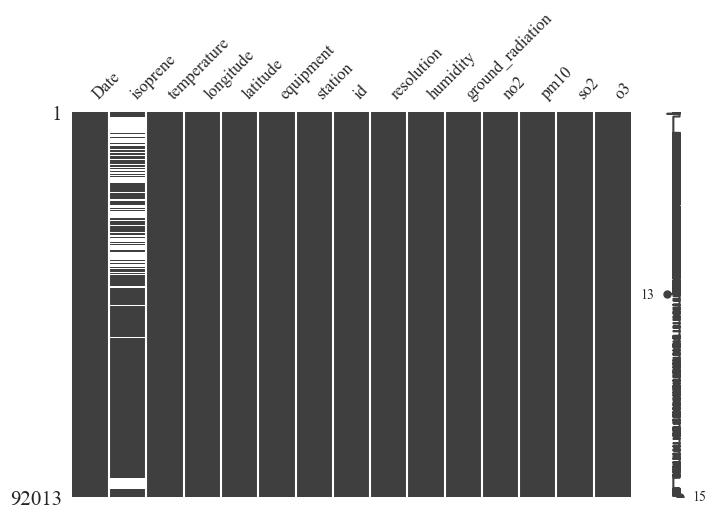

In [34]:
import missingno as msno
msno.matrix(dataebas, figsize=(8, 5), fontsize=12)

非数值列: ['Date', 'equipment', 'station', 'id', 'resolution']
用于插补的数值列: ['Date', 'isoprene', 'temperature', 'longitude', 'latitude', 'equipment', 'station', 'id', 'resolution', 'humidity', 'ground_radiation', 'no2', 'pm10', 'so2', 'o3']


<Axes: >

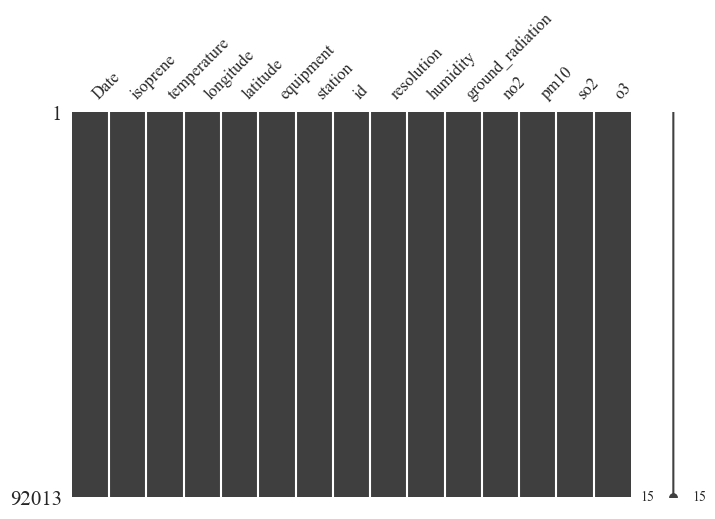

In [35]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from mssa.mssa import mSSA

col = ['isoprene', 'temperature']
filled_data = dataebas.copy()

# 1. 识别非数值列
non_numeric_cols = filled_data.select_dtypes(exclude=[np.number]).columns.tolist()
print(f"非数值列: {non_numeric_cols}")

# 2. 对非数值列进行编码
# 这里以标签编码为例，如果类别无序，可以考虑使用独热编码
label_encoders = {}
for col in non_numeric_cols:
    le = LabelEncoder()
    filled_data[col] = filled_data[col].astype(str)  # 确保所有数据为字符串类型
    filled_data[col] = le.fit_transform(filled_data[col])
    label_encoders[col] = le  # 保存编码器以备后用

# 如果需要使用独热编码，可以使用以下代码：
# filled_data = pd.get_dummies(filled_data, columns=non_numeric_cols, drop_first=True)

# 3. 选择所有数值列（包括编码后的非数值列）
numeric_cols = filled_data.select_dtypes(include=[np.number]).columns.tolist()
print(f"用于插补的数值列: {numeric_cols}")

# 4. 初始化 mSSA 模型
model = mSSA(fill_in_missing=False)

# 更新模型，使用所有数值列
model.update_model(filled_data[numeric_cols])

# 为每个日期时间创建一个整数映射
date_to_int = {date: i for i, date in enumerate(filled_data.index.unique())}

# 5. 对每列中的缺失值进行插值
for column in numeric_cols:
    missing_dates = filled_data[column][filled_data[column].isna()].index
    for date in missing_dates:
        int_index = date_to_int[date]  # 获取整数索引
        prediction = model.predict(column, int_index)["Mean Predictions"]  # 使用整数索引进行预测
        filled_data.at[date, column] = prediction.values[0]  # 更新数据集中的缺失值

# 如果你使用了独热编码，确保在插补后进行适当的处理

# 6. 恢复原始非数值列（如果需要）
for col, le in label_encoders.items():
    filled_data[col] = le.inverse_transform(filled_data[col].astype(int))
msno.matrix(filled_data, figsize=(8, 5), fontsize=12)

In [36]:
filled_data['isoprene'] = filled_data['isoprene'].clip(lower=0)

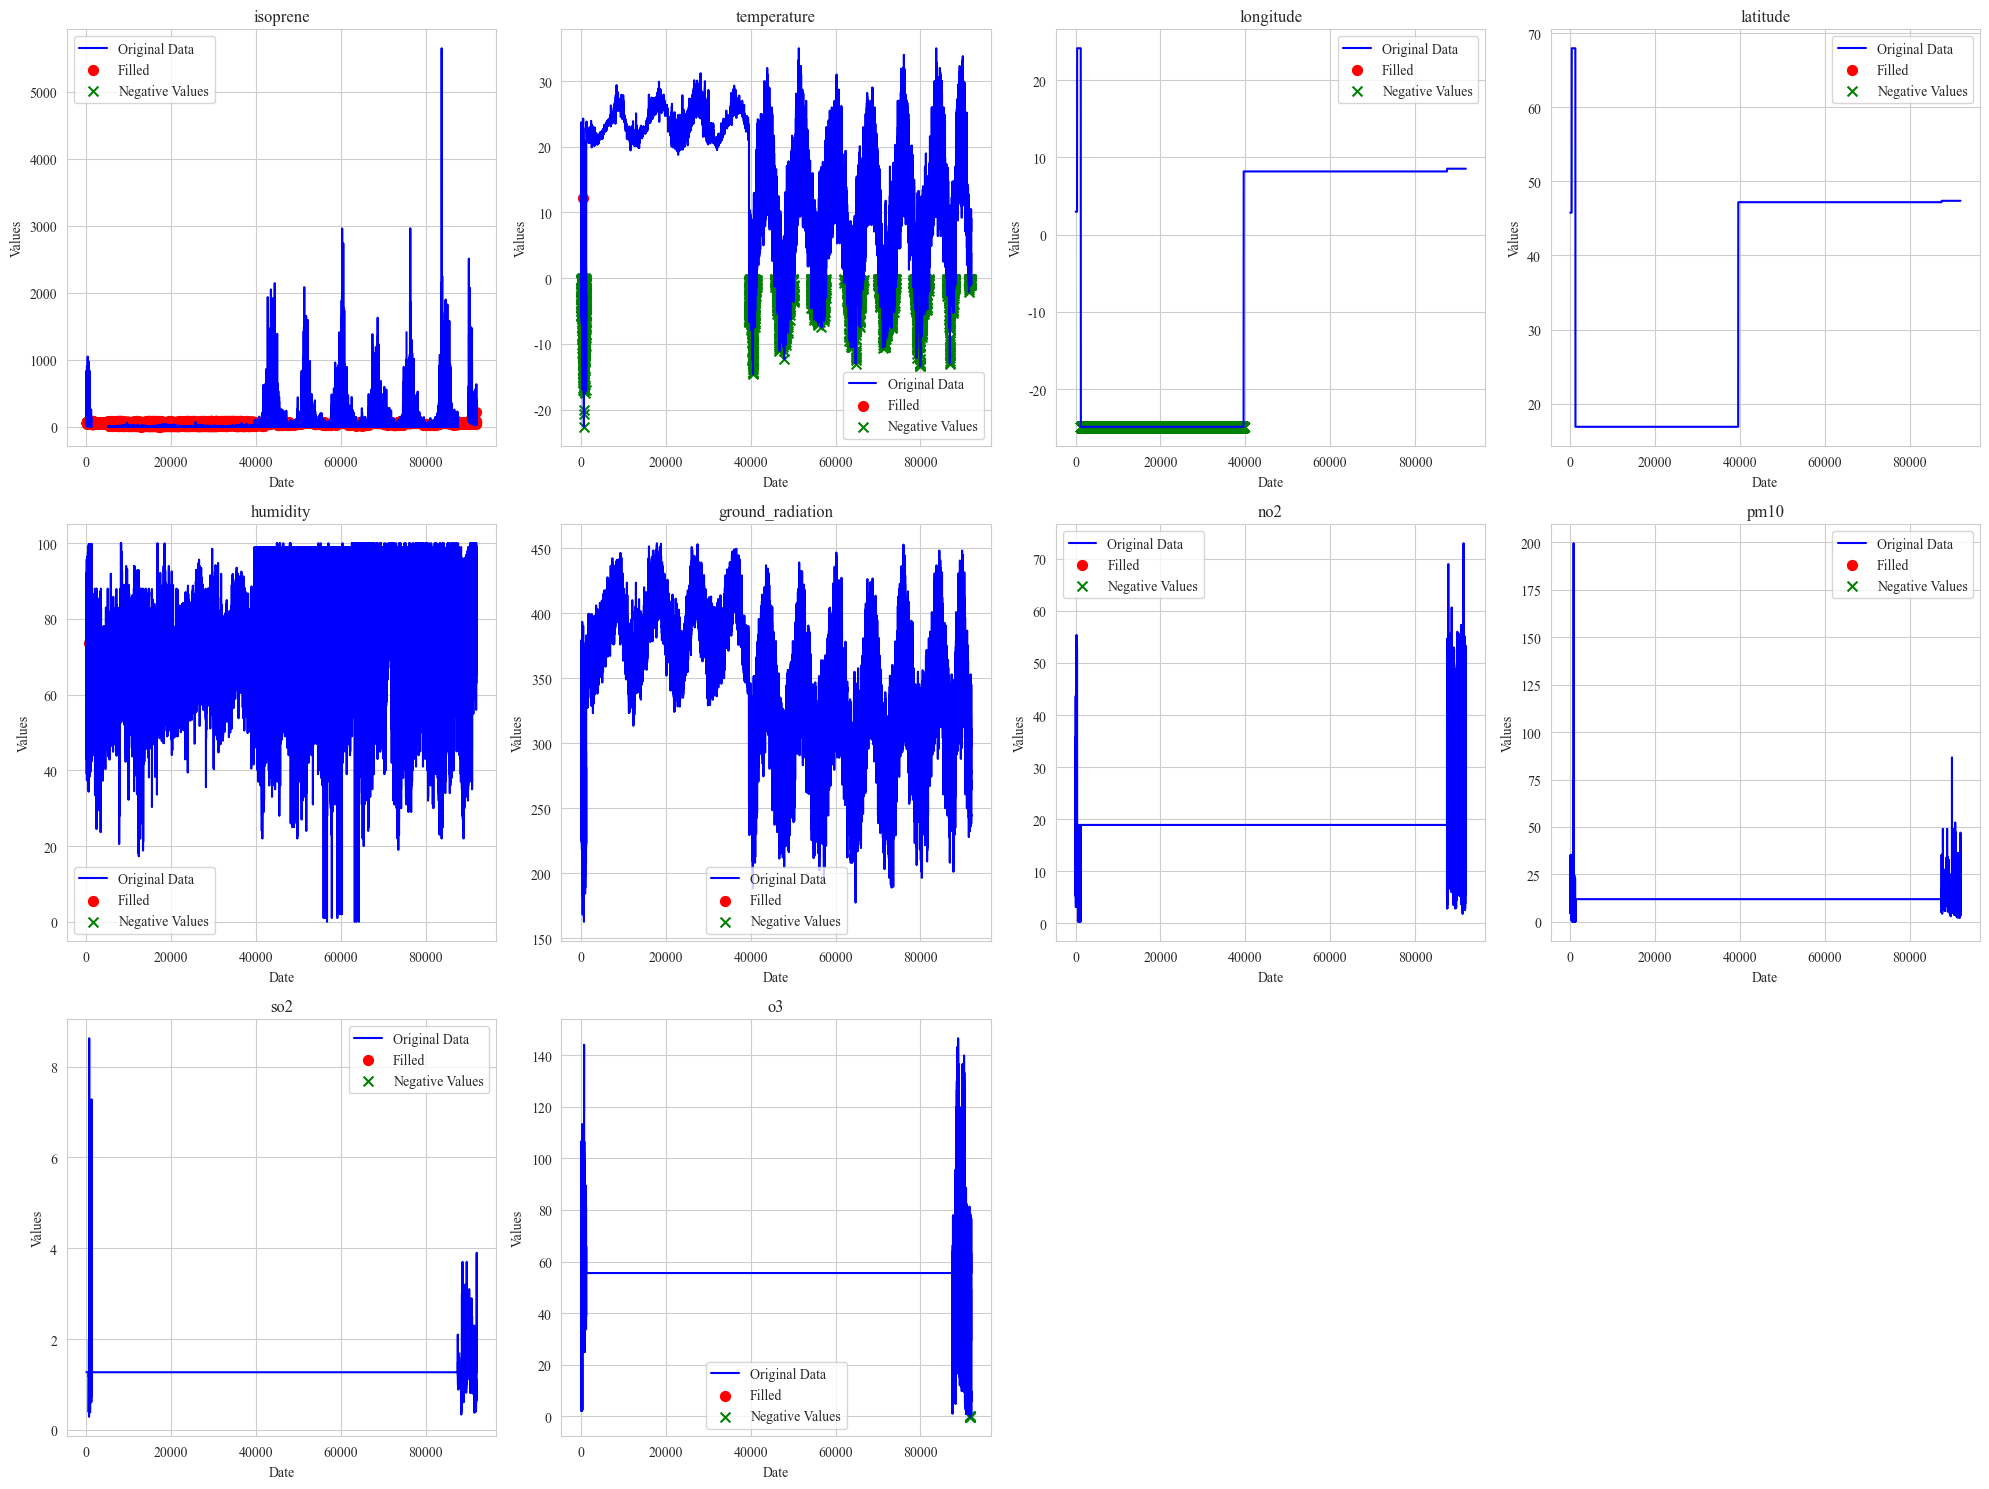

In [37]:
is_filled = filled_data.notna() & dataebas.isna()  # 用于对比哪里被填充了
# 计算需要多少行列来显示所有图
num_vars = filled_data.select_dtypes(include=[np.number]).shape[1]
num_cols = int(np.ceil(np.sqrt(num_vars)))
num_rows = int(np.ceil(num_vars / num_cols))

fig, axes = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 5*num_rows))
axes = axes.flatten()  # 扁平化 axes 数组方便索引

# 遍历每个数值变量，绘制数据并标出填充的位置
for i, column in enumerate(filled_data.select_dtypes(include=[np.number]).columns):
    ax = axes[i]
    # 绘制所有数据
    ax.plot(dataebas.index, dataebas[column], label='Original Data', linestyle='-', marker='', color='blue')
    
    # 特别标记填充的数据点
    filled_indices = filled_data.index[is_filled[column]]
    filled_values = filled_data[column][is_filled[column]]
    ax.scatter(filled_indices, filled_values, color='red', label='Filled', marker='o', s=50)  # 使用红色点标记填充的数据
    
    # 特别标记小于0的值
    negative_indices = filled_data.index[filled_data[column] < 0]
    negative_values = filled_data[column][filled_data[column] < 0]
    ax.scatter(negative_indices, negative_values, color='green', label='Negative Values', marker='x', s=50)  # 使用绿色叉号标记小于0的值

    ax.set_title(column)
    ax.set_xlabel('Date')
    ax.set_ylabel('Values')
    ax.legend()
    ax.grid(True)

# 隐藏多余的轴
for i in range(len(filled_data.select_dtypes(include=[np.number]).columns), len(axes)):
    axes[i].axis('off')

fig.tight_layout()
plt.show()

In [38]:
filled_data.to_pickle('dataebasnona.pkl')
filled_data.to_csv('dataebasnona.csv',index=False)